In [1]:
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

def dim_reduc(hycube,n_components):
    new_hycube =np.reshape(hycube,(-1,hycube.shape[2]))
    pca = PCA(n_components,whiten=True,random_state=0)
    new_hycube = pca.fit_transform(new_hycube)
    new_hycube =np.reshape(new_hycube,(hycube.shape[0],hycube.shape[1],n_components))
    return new_hycube

def patchify(hycube,hycube_y,wsize,padding=True):
    pad = int((wsize-1)/2)
    N = hycube.shape[0]*hycube.shape[1]
    if padding:
        hycube = np.pad(hycube,pad_width=((pad,pad),(pad,pad),(0,0)),constant_values=0)
    new_hycube = np.zeros((N,wsize,wsize,hycube.shape[2]))
    new_hycube_y = np.zeros((N))
    id =0
    for r in range(pad,hycube.shape[0]-pad):
        for c in range(pad,hycube.shape[1]-pad):
            new_hycube[id,:,:,:] = hycube[r-pad:r+pad+1,c-pad:c+pad+1]
            new_hycube_y[id]=hycube_y[r-pad,c-pad]
            id += 1
    return new_hycube,new_hycube_y

def preprocess(hycube,hycube_y,n_components=4,split=True,wsize=25):
    new_hycube = dim_reduc(hycube,n_components)
    for i in range(203):
        for j in range(117):
            if i<100 and j>50 and hycube_y[i,j]==1:
                hycube_y[i,j]=2
            elif i>100 and j<50 and hycube_y[i,j]==1:
                hycube_y[i,j]=3
            elif i>100 and j>50 and hycube_y[i,j]==1:
                hycube_y[i,j]=4
    X,y = patchify(new_hycube,hycube_y,wsize)
    if split:
        X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.80)
        X_train =np.reshape(X_train,(-1,X_train.shape[3],X_train.shape[1],X_train.shape[2]))
        X_test= np.reshape(X_test,(-1,X_test.shape[3],X_test.shape[1],X_test.shape[2]))
        y_train = y_train.astype(int)
        y_test = y_test.astype(int)
        X_train = X_train.astype(np.float32)
        X_test = X_test.astype(np.float32)
        X_train = torch.from_numpy(X_train)
        y_train = torch.from_numpy(y_train)
        X_test = torch.from_numpy(X_test)
        y_test = torch.from_numpy(y_test)
        return X_train,X_test,y_train,y_test
    X = np.reshape(X,(-1,X.shape[3],X.shape[1],X.shape[2]))
    X = X.astype(np.float32)
    y = y.astype(int)
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    return X,y



In [2]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import scipy.io as sio
class HsiDataset(Dataset):
    def __init__(self,transform=ToTensor(),training=True):
        self.transform = transform
        self.training = training
        data = sio.loadmat('prep_data.mat')
        self.hycube = data['prep_sample']
        self.hycube_y = data['prep_mask']
        self.X_train,self.X_test,self.y_train,self.y_test = preprocess(self.hycube,self.hycube_y)
    def __len__(self):
        if self.training:
            return len(self.y_train)
        return len(self.y_test)
    def __getitem__(self, index):
        if self.training:
            X = self.X_train[index]
            y = self.y_train[index]
        else:
            X = self.X_test[index]
            y = self.y_test[index]
        return X,y



In [3]:
import torch.nn as nn
class HSI_CNN(nn.Module):
    def __init__(self,in_channels=4) -> None:
        super(HSI_CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,in_channels*2,5)
        self.conv2 = nn.Conv2d(in_channels*2,in_channels*4,5)
        self.conv3 = nn.Conv2d(in_channels*4,in_channels*4,3)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,64)
        self.linear3 = nn.Linear(64,16)
        self.linear4 = nn.Linear(16,5)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x


In [4]:
model = HSI_CNN()
model

HSI_CNN(
  (conv1): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=5, bias=True)
  (relu): ReLU()
)

In [5]:
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

train_data = HsiDataset()
test_data = HsiDataset(training=False)
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=32)

model = HSI_CNN()
optimizer = Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

best_acc = 0
for epoch in range(50):
    model.train()
    print(f'Epoch: {epoch}')
    # train_loss =0
    for i,(X,y) in enumerate(train_dataloader):
        logits = model(X)
        batch_loss = criterion(logits,y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        # train_loss += batch_loss
        # if i%50 ==0:
        #     print(f'Train Loss: {batch_loss} batch_id: {i}')
    print("Starting eval")
    model.eval()
    # test_loss =0
    epoch_acc = 0
    with torch.no_grad():
        for i,(X,y) in enumerate(test_dataloader):
            logits = model(X)
            # print(X.size())
            batch_loss = criterion(logits,y)
            y_score,y_pred= logits.max(dim=1)
            acc = (y==y_pred).sum()/y.size(0)
            acc = acc.item()
            epoch_acc += acc
            # print(f'Batch Accuracy: {acc} batch_id: {i}')
        if (epoch_acc/(i+1)) > best_acc:
            torch.save(model.state_dict(),'best_model.pth')
            best_acc = (epoch_acc/(i+1))
        print(f'Epoch Eval Accuracy: {epoch_acc/(i+1)}')


Epoch: 0
Starting eval
Epoch Eval Accuracy: 0.9549077181208053
Epoch: 1
Starting eval
Epoch Eval Accuracy: 0.9641359060402684
Epoch: 2
Starting eval
Epoch Eval Accuracy: 0.9714765100671141
Epoch: 3
Starting eval
Epoch Eval Accuracy: 0.9760906040268457
Epoch: 4
Starting eval
Epoch Eval Accuracy: 0.9697986577181208
Epoch: 5
Starting eval
Epoch Eval Accuracy: 0.9821728187919463
Epoch: 6
Starting eval
Epoch Eval Accuracy: 0.979236577181208
Epoch: 7
Starting eval
Epoch Eval Accuracy: 0.9783696868275636
Epoch: 8
Starting eval
Epoch Eval Accuracy: 0.9807046979865772
Epoch: 9
Starting eval
Epoch Eval Accuracy: 0.9825922818791947
Epoch: 10
Starting eval
Epoch Eval Accuracy: 0.9811241610738255
Epoch: 11
Starting eval
Epoch Eval Accuracy: 0.9844798657718121
Epoch: 12
Starting eval
Epoch Eval Accuracy: 0.9815436241610739
Epoch: 13
Starting eval
Epoch Eval Accuracy: 0.989513422818792
Epoch: 14
Starting eval
Epoch Eval Accuracy: 0.9828020134228188
Epoch: 15
Starting eval
Epoch Eval Accuracy: 0.98867

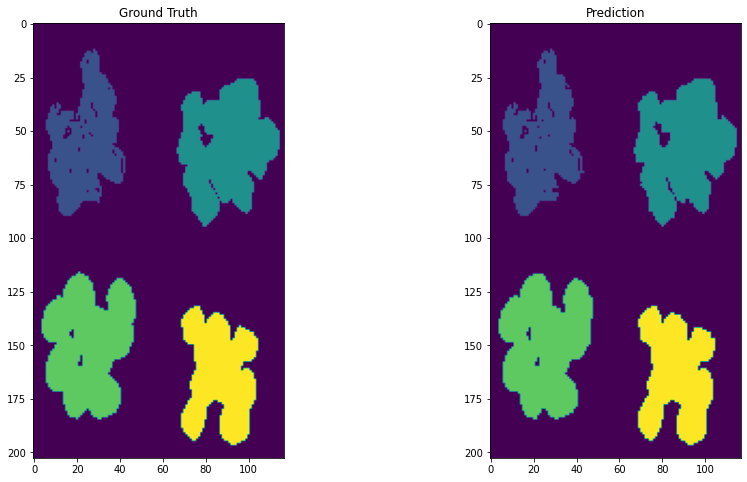

In [7]:
data = sio.loadmat('prep_data.mat')
hycube = data['prep_sample']
hycube_y = data['prep_mask']
h = hycube.shape[0]
w = hycube.shape[1]
# print(h,w)
X,y = preprocess(hycube,hycube_y,split=False,wsize=25)
# print(X.size(),y.size())
pred_img = torch.zeros((h,w))
new_model = HSI_CNN()
new_model.load_state_dict(torch.load('best_model.pth'))
new_model.eval()
id =0
for i in range(h):
    for j in range(w):
        patch = X[id,:,:,:]
        patch = torch.unsqueeze(patch,0)
        # print(patch.size())
        logit = new_model(patch)
        y_score,y_pred = logit.max(dim=1)
        pred_img[i,j] = y_pred
        id+=1
predicted_img = pred_img.numpy()
f,(axs1,axs2) = plt.subplots(1,2,figsize=(15,8))
axs1.set_title('Ground Truth')
axs2.set_title('Prediction')
axs1.imshow(hycube_y)
axs2.imshow(predicted_img)
plt.show()